In [46]:
import torch
import torch.nn as nn
import torch.autograd as autograd

from modules.pinn_2d import *
import matplotlib.pyplot as plt


In [47]:
def make_tensor(x):
    return torch.tensor(x).unsqueeze(0).T.type(torch.FloatTensor).cuda()

In [81]:
x, y = np.mgrid[-0.99:1.01:0.02, -0.99:1.01:0.02]
# x, y = np.mgrid[-1.0:1.00:0.02, -1.0:1.00:0.02]

In [82]:
# fpath = './data_final/models/2d_plate_prob2.data' 
# fpath = './models/2d_plate_prob36.data' 
fpath = './models/2d_plane_prob10.data'
state_dict = torch.load(fpath)

# Points
# points_x = [(-2.0, 0.0), (0.0, 2.0)]
points_x = [(-1.0, 0.0), (0.0, 1.0)]
points_y = [(-1.0, 1.0), (-1.0, 1.0)]

# points_x = [(-1.0, 1.0)]
# points_y = [(-1.0, 1.0)]

# Set the number of domains
domain_no = len(points_x)

# Set the global left & right boundary of the calculation domain
global_lb_x = -2.0
global_rb_x = 2.0
global_lb_y = -1.0
global_rb_y = 1.0

# Initialize CPINN model
model = CPINN_2D(domain_no, global_lb_x, global_rb_x, global_lb_y, global_rb_y, figure_path=None)

# to do
model.make_domains(points_x, points_y)
model.make_boundaries()

sample = {'Model{}'.format(i+1): PINN(i) for i in range(domain_no)}
# sample = {'Model{}'.format(i+1): PINN_plate(i) for i in range(domain_no)}

model.module_update(sample)

model.load_state_dict(state_dict)

model = model.cuda()

[{'x_lb': 0.0, 'x_rb': 0.0, 'y_lb': -1.0, 'y_rb': 1.0}]


In [83]:
xy = torch.from_numpy(np.vstack((x.flatten(), y.flatten()))).type(torch.FloatTensor)
pred = model(xy[0].unsqueeze(0).T.cuda(), xy[1].unsqueeze(0).T.cuda())

In [84]:
models = model.get_models()
wheres = model.wheres
model.boundaries

[{'x_lb': 0.0, 'x_rb': 0.0, 'y_lb': -1.0, 'y_rb': 1.0}]

In [85]:
model_1 = models['Model1']
where_1 = wheres[0]
sep_pred = model_1(xy[0].unsqueeze(0).T.cuda(), xy[1].unsqueeze(0).T.cuda()) * where_1(xy[0].unsqueeze(0).T.cuda(), xy[1].unsqueeze(0).T.cuda())

ValueError: 'c' argument has 20000 elements, which is inconsistent with 'x' and 'y' with size 10000.

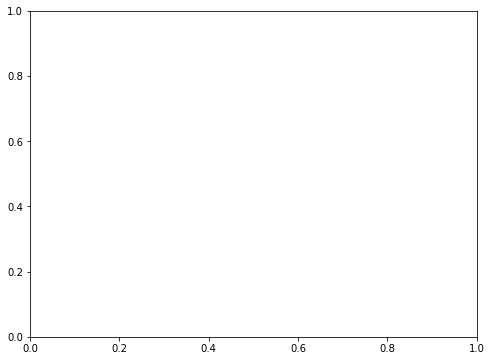

In [86]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=np.abs(sep_pred.cpu().detach().numpy()), cmap='seismic')
plt.colorbar()
plt.ylabel("x (m)")
plt.ylabel("y (m)")
plt.title("u (m) by model")
# plt.savefig("./data/2D_plate_1_u_model.png")

Predict by model - X disp.


In [87]:
x_zero = [-1]
y_zero = [0]

x_zero = torch.tensor(x_zero).type(torch.FloatTensor).unsqueeze(0).T.cuda()
y_zero = torch.tensor(y_zero).type(torch.FloatTensor).unsqueeze(0).T.cuda()

model(x_zero, y_zero)

tensor([[-0.0027,  0.0063]], device='cuda:0', grad_fn=<AddBackward0>)

Text(0.5, 1.0, 'w (m) by PINN')

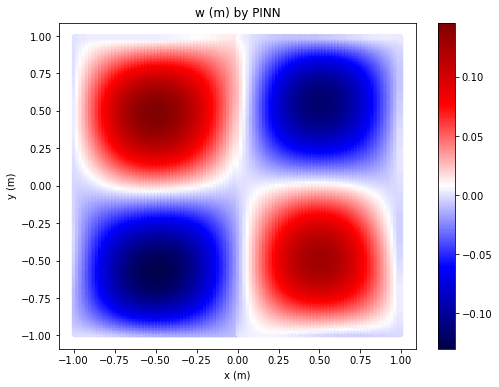

In [88]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=(((pred[:,0].cpu().detach().numpy()))), cmap='seismic')
plt.colorbar()
# plt.clim(0, 0.014)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("w (m) by PINN")
# plt.savefig("./figures/2D_plate_prob2_pinn_1.svg")

Predict by model - Y disp.

Text(0.5, 1.0, 'v (m) by PINN')

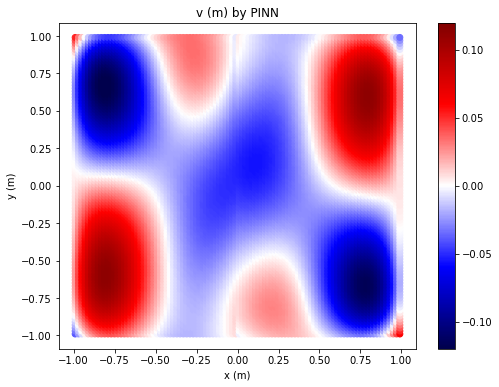

In [65]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=pred[:,1].cpu().detach().numpy(), cmap='seismic')
plt.colorbar()
plt.clim(0.12, -0.12)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("v (m) by PINN")
# plt.savefig("./figures/2D_plane_prob2_v_pinn.svg")

In [94]:
# fname = "./data/2d_plane_prob2_fem.txt"
# fname = "./data/2d_plane_prob3_fem.txt"
fname = "./data_final/FEM/2d_plane_prob2.txt"
data = np.loadtxt(fname=fname)

x, y, u, v = data.T
# x, y, w = data.T

In [114]:
comp_pred = model(torch.tensor(x).unsqueeze(0).T.type(torch.FloatTensor).cuda(), torch.tensor(y).unsqueeze(0).T.type(torch.FloatTensor).cuda())

In [115]:
u_pred = comp_pred[:,0].cpu().detach().numpy()
v_pred = comp_pred[:,1].cpu().detach().numpy()
u_diff = u_pred.reshape(-1, 1) - u.reshape(-1, 1)
v_diff = v_pred.reshape(-1, 1) - v.reshape(-1, 1)
v_pred

array([-0.03983008, -0.02422401, -0.01069624, ..., -0.00996922,
       -0.02244353, -0.03685112], dtype=float32)

Predict by FEM - X disp.

Text(0.5, 1.0, 'w (m) by FEM')

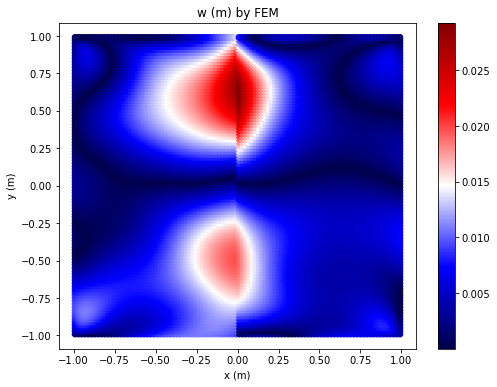

In [118]:
plt.figure(figsize=(8, 6))

plt.scatter(x, y, c=abs(u_diff), cmap='seismic')
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("w (m) by FEM")
# plt.clim(0, 0.012)

# plt.savefig("./figures/2D_plate_prob2_fem_1.svg")

Predict by FEM - Y disp.

Text(0.5, 1.0, 'v (m) by FEM')

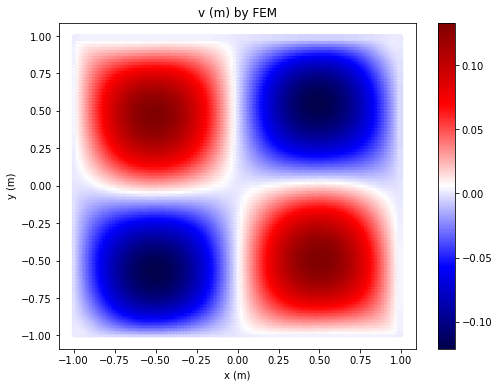

In [120]:
plt.figure(figsize=(8, 6))

plt.scatter(x, y, c=u, cmap='seismic')
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("v (m) by FEM")
# plt.clim(0.12, -0.12)
# plt.savefig("./figures/2D_plane_prob2_v_fem.svg")

In [23]:
comp_pred = model(torch.tensor(x).unsqueeze(0).T.type(torch.FloatTensor).cuda(), torch.tensor(y).unsqueeze(0).T.type(torch.FloatTensor).cuda())

In [24]:
comp_pred = abs(comp_pred)

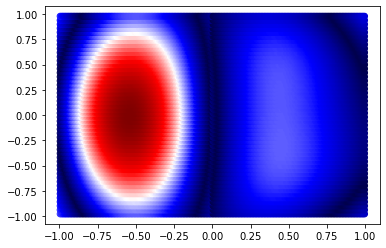

In [25]:
plt.scatter(x, y, c=comp_pred.detach().cpu().numpy(), cmap='seismic')

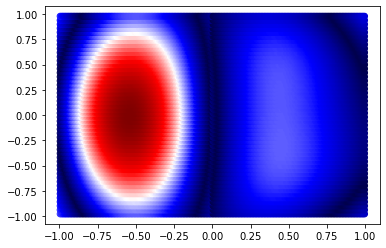

In [18]:
plt.scatter(x, y, c=comp_pred.cpu().detach().numpy(), cmap='seismic')

In [63]:
w.shape

(10000,)

In [21]:
comp_pred_np = comp_pred.T.cpu().detach().numpy().T
# comp_pred_np = comp_pred_np.reshape(100, 100).T.reshape(-1, 1)
# u_np = np.expand_dims(u, axis=0)
# u_np.shape
# v_np = np.expand_dims(v, axis=0)
# comp_pred_np.shape
w_np = np.expand_dims(w, axis=0).reshape(-1, 1)

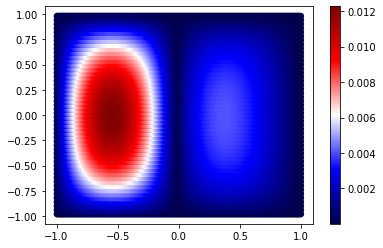

In [22]:
plt.scatter(x, y, c=w_np, cmap='seismic')
plt.colorbar()

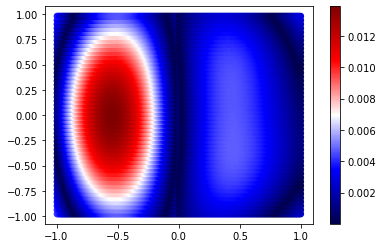

In [26]:
plt.scatter(x, y, c=comp_pred_np, cmap='seismic')
plt.colorbar()

In [27]:
# diff_u = ((comp_pred_np[0,:] - u_np)).T
# diff_v = ((comp_pred_np[1,:] - v_np)).T
diff_w = ((comp_pred_np - w_np)).T



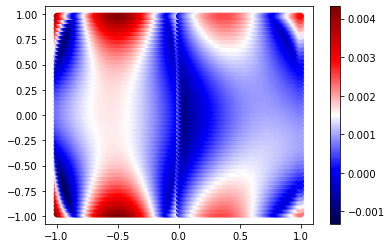

In [28]:
plt.scatter(x, y, c=diff_w, cmap='seismic')
plt.colorbar()

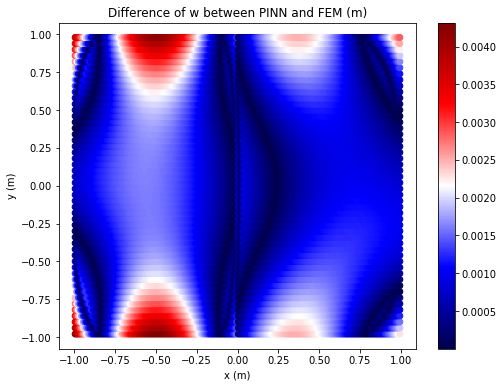

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=abs(diff_w), cmap='seismic')
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Difference of w between PINN and FEM (m)")
plt.savefig("./data_final/figures/2D_plate_prob2_w_diff.svg")